In [22]:
import os
import pandas as pd
from pathlib import Path
import re
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

In [23]:
# RAVDESS

path = 'datasets/archive/audio_speech_actors_01-24'

train_data = []
test_data = []

# Speaker split (gender-balanced)
train_speakers = ["01", "03", "05", "07", "09", "11", "13", "15", "17", "19", "02", "04", "06", "08", "10", "12", "14", "16", "18", "20"]
test_speakers = ["21", "23", "22", "24"]

emotion_map = {
    "01": "neutral",
    # "02": "calm",  -> remove not in crema-d
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    # "08": "surprised" -> remove not in crema-d
}

for folder in sorted(os.listdir(path)):
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
        match = re.match(r"(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)\.wav", file)
        if match:
            filepath = str(Path(path) / folder / file)
            indicators = match.groups()
            emotion_code = indicators[2]
            actor_id = indicators[-1]
            gender = 'Female' if int(indicators[-1]) % 2 == 0 else 'Male'
            if emotion_code not in emotion_map:
                continue

            record = {
                "path": filepath,
                "emotion": emotion_map[emotion_code],
                "gender": gender,
                "source": "RAVDESS"
            }

            if actor_id in train_speakers:
                train_data.append(record)
            else:
                test_data.append(record)

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

In [24]:
demo_df = pd.read_csv('datasets/CREMA-D/VideoDemographics.csv')
print(demo_df.head(10))
print(demo_df.columns)

   ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic
5     1006   58  Female         Caucasian  Not Hispanic
6     1007   38  Female  African American  Not Hispanic
7     1008   46  Female         Caucasian  Not Hispanic
8     1009   24  Female         Caucasian  Not Hispanic
9     1010   27  Female         Caucasian  Not Hispanic
Index(['ActorID', 'Age', 'Sex', 'Race', 'Ethnicity'], dtype='object')


In [25]:
# CREMA-D

path = 'datasets/CREMA-D/AudioWAV'

# Load demographics for gender mapping
demo_df = pd.read_csv('datasets/CREMA-D/VideoDemographics.csv')
gender_map = dict(zip(demo_df['ActorID'], demo_df['Sex']))

# Check how many actors
print(f"Total actors: {len(gender_map)}")
print(f"Males: {list(gender_map.values()).count('Male')}")
print(f"Females: {list(gender_map.values()).count('Female')}")

Total actors: 91
Males: 48
Females: 43


In [26]:
train_data = []
test_data = []

emotion_map = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

# Get all actor IDs and split by gender
all_actors = demo_df['ActorID'].tolist()
male_actors = demo_df[demo_df['Sex'] == 'Male']['ActorID'].tolist()
female_actors = demo_df[demo_df['Sex'] == 'Female']['ActorID'].tolist()

# 80/20 split per gender
train_males = male_actors[:38]      # 38 males for train
test_males = male_actors[38:]       # 10 males for test

train_females = female_actors[:34]  # 34 females for train  
test_females = female_actors[34:]   # 9 females for test

train_speakers = train_males + train_females  # 72 speakers
test_speakers = test_males + test_females      # 19 speakers

print(f"\nTrain speakers: {len(train_speakers)} ({len(train_males)}M, {len(train_females)}F)")
print(f"Test speakers: {len(test_speakers)} ({len(test_males)}M, {len(test_females)}F)")

# Parse audio files
for file in os.listdir(path):
    if not file.endswith('.wav'):
        continue
        
    # Filename: 1001_IEO_ANG_HI.wav
    parts = file.replace('.wav', '').split('_')
    
    if len(parts) < 4:
        continue
    
    actor_id = int(parts[0])
    emotion_code = parts[2]
    
    if emotion_code not in emotion_map:
        continue
    
    filepath = str(Path(path) / file)
    gender = gender_map.get(actor_id, 'Unknown')
    
    record = {
        "path": filepath,
        "emotion": emotion_map[emotion_code],
        "gender": gender,
        "source": "CREMA-D"
    }
    
    if actor_id in train_speakers:
        train_data.append(record)
    elif actor_id in test_speakers:
        test_data.append(record)

# Create DataFrames
train_df_cremad = pd.DataFrame(train_data)
test_df_cremad = pd.DataFrame(test_data)

# Verify
print("\nCREMA-D TRAIN:")
print(f"  Samples: {len(train_df_cremad)}")
print(f"  By gender: {train_df_cremad['gender'].value_counts().to_dict()}")

print("\nCREMA-D TEST:")
print(f"  Samples: {len(test_df_cremad)}")
print(f"  By gender: {test_df_cremad['gender'].value_counts().to_dict()}")


Train speakers: 72 (38M, 34F)
Test speakers: 19 (10M, 9F)

CREMA-D TRAIN:
  Samples: 5885
  By gender: {'Male': 3110, 'Female': 2775}

CREMA-D TEST:
  Samples: 1557
  By gender: {'Male': 820, 'Female': 737}


In [27]:
# Combine with RAVDESS
train_df = pd.read_csv("train_split.csv")
test_df = pd.read_csv("test_split.csv")

train_df = pd.concat([train_df, train_df_cremad], ignore_index=True)
test_df = pd.concat([test_df, test_df_cremad], ignore_index=True)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print(f"\nFINAL TRAIN: {len(train_df)}")
print(f"FINAL TEST: {len(test_df)}")


FINAL TRAIN: 6765
FINAL TEST: 1733


In [28]:
# quick check to ensure "calm" emotion is removed
print(train_df['emotion'].unique())

['neutral' 'happy' 'sad' 'angry' 'fearful' 'disgust']


In [29]:
sample_path = train_df.iloc[0]['path']
sample_emotion = train_df.iloc[0]['emotion']
print (f"Sample path: {sample_path},\nemotion: {sample_emotion}")

Sample path: datasets\archive\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav,
emotion: neutral


In [30]:
waveform, sr = librosa.load(sample_path, sr=16000)
print(f"\nOriginal:")
print(f"  Sample rate: {sr} Hz")
print(f"  Shape: {waveform.shape}")
print(f"  Duration: {len(waveform)/sr:.2f} seconds")


Original:
  Sample rate: 16000 Hz
  Shape: (52853,)
  Duration: 3.30 seconds


In [31]:
# pad / truncate to 3 seconds
target_length = 48000  # 3 seconds at 16kHz
original_length = len(waveform)
if original_length < target_length:
    waveform = np.pad(waveform, (0, target_length - original_length))
    print(f"\nPadded from {original_length} to {target_length} samples")
else:
    waveform = waveform[:target_length]
    print(f"\nTruncated from {original_length} to {target_length} samples")

print(f"Final waveform shape: {waveform.shape}")


Truncated from 52853 to 48000 samples
Final waveform shape: (48000,)


In [32]:
mel_spec = librosa.feature.melspectrogram(
    y=waveform,
    sr=sr,
    n_mels = 128,
    n_fft=2048,
    hop_length=512
)
print(f"\nMel-spectrogram shape: {mel_spec.shape}")


Mel-spectrogram shape: (128, 94)


In [33]:
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
print(f"Mel-spectrogram (dB) shape: {mel_spec_db.shape}")

Mel-spectrogram (dB) shape: (128, 94)


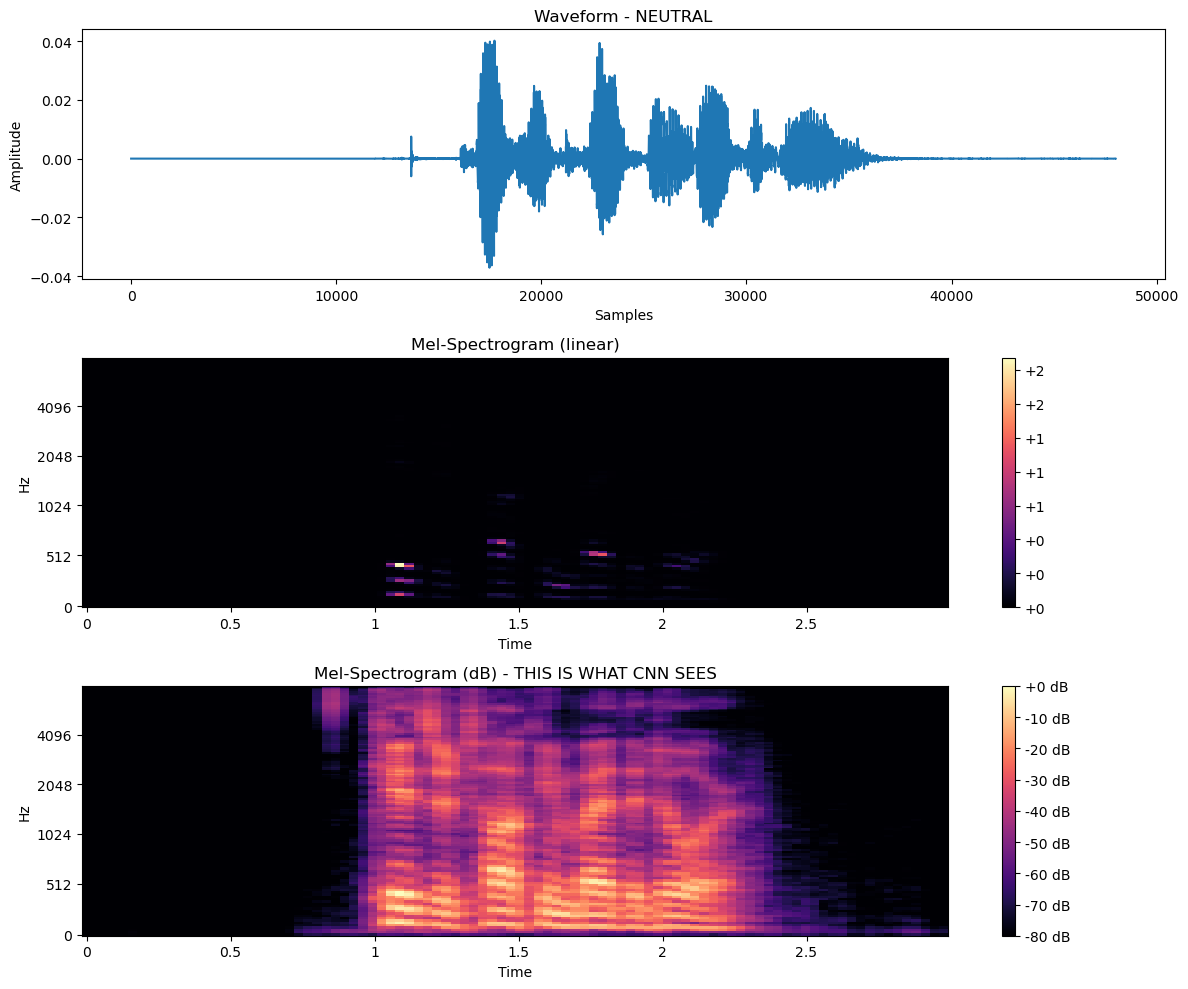


SUMMARY - What goes into CNN:
Input shape: (1, 128, 94)
  - Channels: 1 (grayscale image)
  - Mel bands: 128 (height = 128)
  - Time frames: 94 (width)
Label: neutral


In [34]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot waveform
axes[0].plot(waveform)
axes[0].set_title(f'Waveform - {sample_emotion.upper()}')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

# Plot mel-spectrogram (linear)
img1 = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=sr, ax=axes[1])
axes[1].set_title('Mel-Spectrogram (linear)')
fig.colorbar(img1, ax=axes[1], format='%+2.0f')

# Plot mel-spectrogram in dB - THIS IS WHAT CNN SEES
img2 = librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, ax=axes[2])
axes[2].set_title('Mel-Spectrogram (dB) - THIS IS WHAT CNN SEES')
fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()
plt.savefig('audio_analysis.png', dpi=150)
plt.show()

print("\n" + "="*50)
print("SUMMARY - What goes into CNN:")
print("="*50)
print(f"Input shape: (1, {mel_spec_db.shape[0]}, {mel_spec_db.shape[1]})")
print(f"  - Channels: 1 (grayscale image)")
print(f"  - Mel bands: {mel_spec_db.shape[0]} (height = 128)")
print(f"  - Time frames: {mel_spec_db.shape[1]} (width)")
print(f"Label: {sample_emotion}")

128 mel bands - frequency range leading up to 48000hz (3 sec time)

94 time windows

hence the shape (128, 94)

notice the power db graph (scale adjusted for human audible samples) - we set the loudest volume (highest amplitude) to 0, closest to that will be loude voice represented with bright colors and then leading away from it is quiter around -80 db

In [35]:
class EmotionDataset(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment
        
        # Emotion to number mapping
        self.emotion_to_idx = {
            'angry': 0,
            'disgust': 1,
            'fearful': 2,
            'happy': 3,
            'neutral': 4,
            'sad': 5
        }
        
        # Audio settings
        self.sample_rate = 16000
        self.duration = 3  # seconds
        self.target_length = self.sample_rate * self.duration  # 48000
        
        # Mel-spectrogram settings
        self.n_mels = 128
        self.n_fft = 2048
        self.hop_length = 512
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. Load audio (librosa auto-converts to mono and resamples)
        waveform, sr = librosa.load(row['path'], sr=self.sample_rate, mono=True)
        
        # 2. Pad or truncate to 3 seconds
        if len(waveform) < self.target_length:
            waveform = np.pad(waveform, (0, self.target_length - len(waveform)))
        else:
            waveform = waveform[:self.target_length]

        if self.augment:
            # Time shift
            shift = np.random.randint(-4000, 4000)
            waveform = np.roll(waveform, shift)
            
            # Add noise
            noise = np.random.normal(0, 0.005, waveform.shape)
            waveform = waveform + noise
            
            # Random volume
            volume = np.random.uniform(0.8, 1.2)
            waveform = waveform * volume
        
        # 3. Convert to mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=waveform,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # 4. Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 5. Normalize to 0-1 range (helps CNN learn better)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
        
        # 6. Convert to tensor and add channel dimension
        mel_spec_tensor = torch.FloatTensor(mel_spec_db).unsqueeze(0)  # Shape: (1, 128, 94)
        
        # 7. Get label
        label = self.emotion_to_idx[row['emotion']]
        
        return mel_spec_tensor, label

In [36]:
# # Test
# train_dataset = EmotionDataset('train_split.csv')
# mel_spec, label = train_dataset[0]
# print(f"Mel-spectrogram shape: {mel_spec.shape}")
# print(f"Label: {label}")

In [37]:
class EmotionResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EmotionResNet, self).__init__()
        
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify first conv layer to accept 1 channel instead of 3
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # adding dropout layer
        self.dropout = nn.Dropout(0.5)

        # Modify final layer for 6 classes
        self.resnet.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout here
        x = self.resnet.fc(x)

        return x

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [39]:
# Datasets
train_dataset = EmotionDataset('train_split.csv')
test_dataset = EmotionDataset('test_split.csv')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
print(f"Train: {len(train_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Train: 6765 samples
Test: 1733 samples


In [41]:
# Model
model = EmotionResNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

m:\anaconda\envs\alex\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
m:\anaconda\envs\alex\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
epochs = 20
highest_acc = 0.0

for epoch in range(epochs):

    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for mel_specs, labels in train_loader:
        mel_specs = mel_specs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(mel_specs)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * (train_correct / train_total)

    # test each epoch to save the the model with highest accuracy
    model.eval()
    test_correct = 0
    test_total = 0 

    with torch.no_grad():
        for mel_specs, labels in test_loader:
            mel_specs = mel_specs.to(device)
            labels = labels.to(device)
            
            outputs = model(mel_specs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_acc = 100 * test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if test_acc > highest_acc:
        highest_acc = test_acc
        torch.save(model.state_dict(), 'model/best_emotion_resnet.pth')
        print(f"  -> New highest accuracy: {highest_acc:.2f}%, model saved.")

Epoch 1/20 | Train Acc: 39.44% | Test Acc: 45.93%
  -> New highest accuracy: 45.93%, model saved.
Epoch 2/20 | Train Acc: 55.25% | Test Acc: 47.72%
  -> New highest accuracy: 47.72%, model saved.
Epoch 3/20 | Train Acc: 65.13% | Test Acc: 48.24%
  -> New highest accuracy: 48.24%, model saved.
Epoch 4/20 | Train Acc: 75.02% | Test Acc: 46.62%
Epoch 5/20 | Train Acc: 83.53% | Test Acc: 48.87%
  -> New highest accuracy: 48.87%, model saved.
Epoch 6/20 | Train Acc: 91.22% | Test Acc: 46.80%
Epoch 7/20 | Train Acc: 92.76% | Test Acc: 50.32%
  -> New highest accuracy: 50.32%, model saved.
Epoch 8/20 | Train Acc: 94.69% | Test Acc: 48.82%
Epoch 9/20 | Train Acc: 95.48% | Test Acc: 47.55%
Epoch 10/20 | Train Acc: 96.13% | Test Acc: 47.84%
Epoch 11/20 | Train Acc: 96.69% | Test Acc: 48.59%
Epoch 12/20 | Train Acc: 97.28% | Test Acc: 50.03%
Epoch 13/20 | Train Acc: 97.06% | Test Acc: 51.01%
  -> New highest accuracy: 51.01%, model saved.
Epoch 14/20 | Train Acc: 96.82% | Test Acc: 48.64%
Epoch 1